## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [37]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import chain
from random import sample
import pickle

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix
import sklearn.model_selection as skl
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint,EarlyStopping

## Do some early processing of your metadata for easier model training:

In [8]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
84326,00020725_024.png,Atelectasis|Effusion,24,20725,50,M,AP,3056,2544,0.139,0.139,NaN,/data/images_009/images/00020725_024.png
55550,00013911_019.png,No Finding,19,13911,64,M,PA,2750,2832,0.143,0.143,NaN,/data/images_007/images/00013911_019.png
99091,00026203_007.png,Effusion,7,26203,47,F,AP,3056,2544,0.139,0.139,NaN,/data/images_011/images/00026203_007.png


In [9]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
91238,00022755_000.png,No Finding,0,22755,47,M,PA,2544,3032,0.139000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
40142,00010475_044.png,No Finding,44,10475,64,F,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
107540,00029046_000.png,No Finding,0,29046,52,M,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [10]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification
all_xray_df['pneumonia_class']=all_xray_df['Pneumonia'].apply(int).apply(str)
all_xray_df.sample(3)
# Todo

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
108390,00029379_002.png,Infiltration,2,29379,41,F,PA,2021,2021,0.194311,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
34752,00009166_007.png,Fibrosis,7,9166,59,F,PA,2048,2500,0.168000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
84171,00020691_000.png,No Finding,0,20691,75,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0


## Create your training and testing data:

In [12]:
def create_splits(vargs):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    train_data, val_data = skl.train_test_split(vargs, 
                                   test_size = 0.2, 
                                   stratify = vargs['pneumonia_class'])
    
    p_inds=train_data[train_data['pneumonia_class']=='1'].index.tolist()
    np_inds=train_data[train_data['pneumonia_class']=='0'].index.tolist()
    np_sample = sample(np_inds,len(p_inds))
    train_data = train_data.loc[p_inds + np_sample]
    
    v_p_inds=val_data[val_data['pneumonia_class']=='1'].index.tolist()
    v_np_inds=val_data[val_data['pneumonia_class']=='0'].index.tolist()
    v_np_sample = sample(v_np_inds,4*len(v_p_inds))
    val_data = val_data.loc[v_p_inds + v_np_sample]
    
    return train_data, val_data

In [13]:
train_df,val_df=create_splits(all_xray_df)

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [14]:
IMG_SIZE = (224, 224)

In [15]:
def my_image_augmentation(h_shift,w_shift,rotation,shear,zoom):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    my_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= h_shift, 
                              width_shift_range=w_shift, 
                              rotation_range=rotation, 
                              shear_range = shear,
                              zoom_range=zoom)
    return my_idg


def make_train_gen(my_train_idg,train_df):
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
                                          directory=None, 
                                          x_col ='path',
                                          y_col = 'pneumonia_class',
                                          class_mode = 'binary',
                                          target_size = IMG_SIZE, 
                                          batch_size = 256
                                          )
    return train_gen


def make_val_gen(val_df,batch_size):
    my_val_idg=ImageDataGenerator(rescale=1. / 255.0)
    val_gen = my_val_idg.flow_from_dataframe(dataframe = val_df,
                                             directory=None, 
                                             x_col = 'path',
                                             y_col = 'pneumonia_class',
                                             class_mode = 'binary',
                                             target_size = IMG_SIZE, 
                                             batch_size = batch_size) 
    return val_gen

In [16]:
my_train_idg=my_image_augmentation(0.1,0.1,10,0.1,0.1)
train_gen=make_train_gen(my_train_idg,train_df)

Found 2290 validated image filenames belonging to 2 classes.


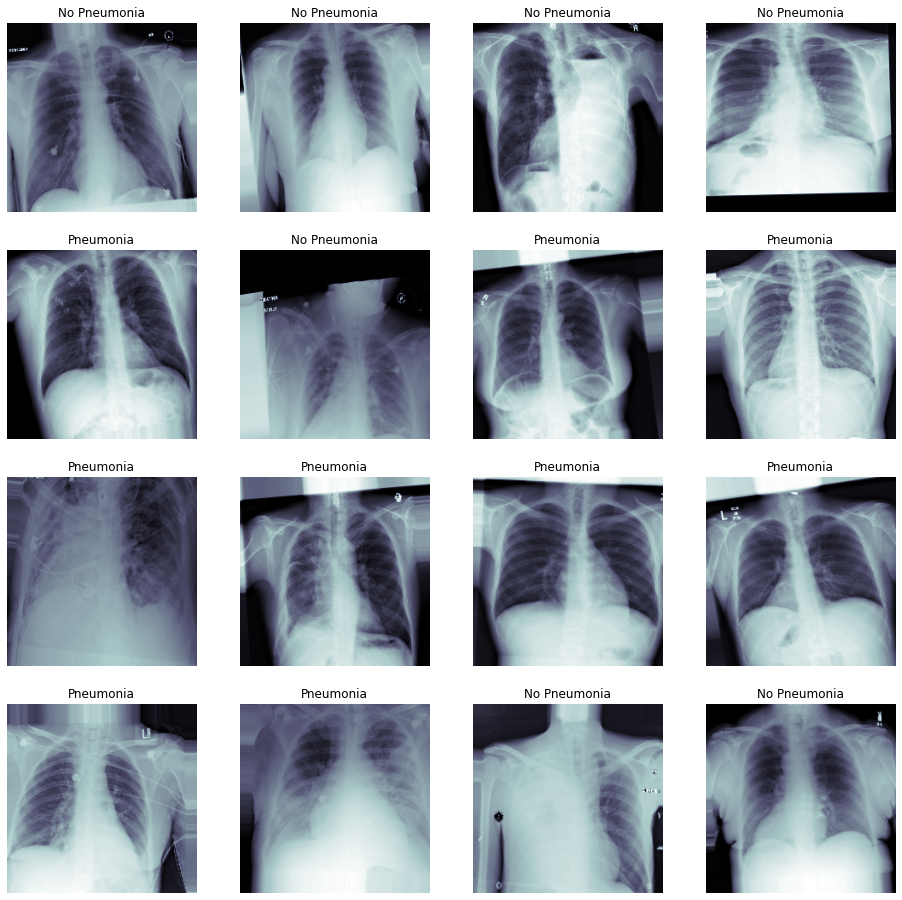

In [17]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [18]:
def load_pretrained_model(lay_of_interest):
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer(lay_of_interest)
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    
    return vgg_model


In [19]:
vgg_model=load_pretrained_model('block5_pool')

553467904/553467096 [==============================] - 7s 0us/step


In [20]:
def build_my_model(pretrained_model):
    
    my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    for layer in pretrained_model.layers[0:-2]:
        layer.trainable = False
    my_model.add(pretrained_model)
    my_model.add(Flatten())
    my_model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(lr=2e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return my_model

def build_my_model_1(pretrained_model):
    
    my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    for layer in pretrained_model.layers[0:-2]:
        layer.trainable = False
    my_model.add(pretrained_model)
    my_model.add(Flatten())
    my_model.add(Dense(1024, activation='relu'))
    my_model.add(Dropout(0.2))
    my_model.add(Dense(512, activation='relu'))
    my_model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(lr=2e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return my_model

def build_my_model_2(pretrained_model):
    
    my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    for layer in pretrained_model.layers[0:-2]:
        layer.trainable = False
    my_model.add(pretrained_model)
    my_model.add(Flatten())
    my_model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(lr=1e-3)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return my_model
## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [21]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                              monitor= 'val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                              mode= 'min', 
                              save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                       mode= 'min', 
                       patience=5)

callbacks_list = [checkpoint, early]

### Start training! 

In [15]:
val_gen=make_val_gen(val_df,512)
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

Found 1430 validated image filenames belonging to 2 classes.


**Neural networks with different architectures (build_my_model, build_my_model_1, build_my_model_2) were tried and build_my_model showed the best performance, so only its result is shown here.**

In [19]:
## build_my_model_1
my_model=build_my_model(vgg_model)
# Todo

history_model = my_model.fit_generator(train_gen, 
                           validation_data = (valX, valY), 
                           epochs = 10, 
                           callbacks = callbacks_list)

Epoch 1/10
9/9 [==============================] - 73s 8s/step - loss: 0.7074 - binary_accuracy: 0.5419 - val_loss: 0.7270 - val_binary_accuracy: 0.5098

Epoch 00001: val_loss improved from inf to 0.72696, saving model to xray_class_my_model.best.hdf5
Epoch 2/10
9/9 [==============================] - 61s 7s/step - loss: 0.6625 - binary_accuracy: 0.6031 - val_loss: 0.6307 - val_binary_accuracy: 0.6230

Epoch 00002: val_loss improved from 0.72696 to 0.63069, saving model to xray_class_my_model.best.hdf5
Epoch 3/10
9/9 [==============================] - 60s 7s/step - loss: 0.6493 - binary_accuracy: 0.6266 - val_loss: 0.5546 - val_binary_accuracy: 0.7207

Epoch 00003: val_loss improved from 0.63069 to 0.55458, saving model to xray_class_my_model.best.hdf5
Epoch 4/10
9/9 [==============================] - 59s 7s/step - loss: 0.6496 - binary_accuracy: 0.6231 - val_loss: 0.5253 - val_binary_accuracy: 0.7461

Epoch 00004: val_loss improved from 0.55458 to 0.52529, saving model to xray_class_my_

In [22]:
with open('history_model.pkl','rb') as f: 
    history_model = pickle.load(f)

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [26]:
from keras.models import model_from_json


model_path = 'my_model.json'
weight_path = 'xray_class_my_model.best.hdf5'

json_file = open(model_path, 'r')
loaded_model_json = json_file.read()
json_file.close()
my_model = model_from_json(loaded_model_json)
# load weights into new model
my_model.load_weights(weight_path)


In [23]:
#Use all validation data
my_val_idg=ImageDataGenerator(rescale=1. / 255.0)
val_gen = my_val_idg.flow_from_dataframe(dataframe = val_df,
                                         directory=None, 
                                         x_col = 'path', 
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         shuffle=False,
                                         batch_size = 1430)
valX_all, valY_all = val_gen.next()

Found 1430 validated image filenames belonging to 2 classes.


In [27]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.

pred_Y_all = my_model.predict(valX_all, batch_size = 32, verbose = True)

1430/1430 [==============================] - 871s 609ms/step


In [17]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    fpr, tpr, thresholds  = roc_curve(t_y, p_y)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,tpr,label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    # Todo    
    return

def plot_pr(t_y, p_y):
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    plt.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    plt.legend()
    plt.xlabel('Recall')
    plt.ylabel('Precision')

def  calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)

def plot_history(history):
    N = len(history.history["loss"])
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    return

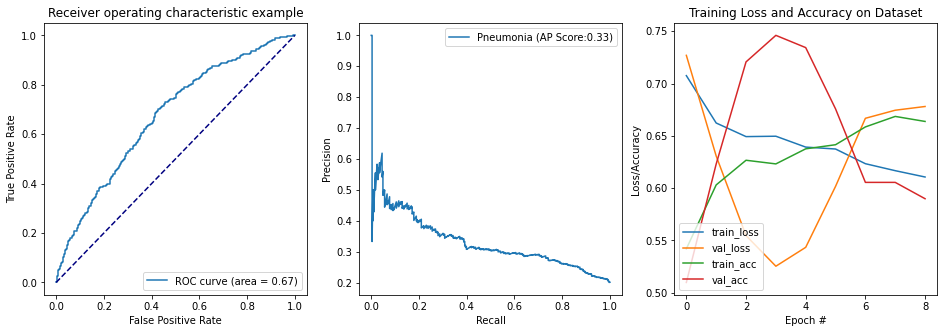

In [40]:
## plot figures
plt.figure(figsize=(16,5))
plt.subplot(131)
plot_auc(valY_all, pred_Y_all)
plt.subplot(132)
plot_pr(valY_all, pred_Y_all)
plt.subplot(133)
plot_history(history_model)
# Todo

In [45]:
val_df['pred_Y']=pred_Y_all
val_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class,pred_Y
44790,00011514_015.png,Pneumonia,15,11514,46,M,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0.487407
6060,00001637_001.png,Pneumonia,1,1637,23,M,PA,1960,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0.374054
37345,00009858_001.png,Effusion|Pneumonia,1,9858,48,F,PA,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0.339924
87248,00021547_001.png,Edema|Infiltration|Pneumonia,1,21547,51,M,AP,3056,2544,0.139000,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0.369159
70022,00017236_104.png,Edema|Pneumonia,104,17236,46,M,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0.644253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98494,00026028_000.png,Infiltration,0,26028,60,M,PA,3056,2544,0.139000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.111434
24,00000008_001.png,No Finding,1,8,70,F,PA,2048,2500,0.171000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.088895
76460,00018770_000.png,No Finding,0,18770,51,M,PA,2806,2893,0.143000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.220354
16645,00004461_003.png,Cardiomegaly|Effusion|Fibrosis,3,4461,45,M,PA,2020,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.362583


Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

Text(0, 0.5, 'F1 scores')

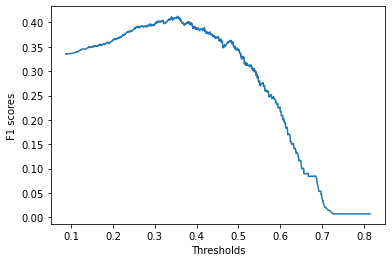

In [21]:
precision, recall, thresholds = precision_recall_curve(val_df['Pneumonia'], val_df['pred_Y'])
f1_scores=calc_f1(precision,recall)
plt.plot(thresholds,f1_scores[0:-1])
plt.xlabel('Thresholds')
plt.ylabel('F1 scores')

In [23]:
idx = f1_scores.argmax() 
print('Largest F1 Score is: ' + str(f1_scores[idx]))
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))


Largest F1 Score is: 0.4127310061601643
Precision is: 0.2921511627906977
Recall is: 0.7027972027972028
Threshold is: 0.35509855


In [25]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.
recall_value = 0.8
idx = (np.abs(recall - recall_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))
# Todo

Precision is: 0.26171428571428573
Recall is: 0.8006993006993007
Threshold is: 0.29349056
F1 Score is: 0.39448751076658056


In [26]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.
recall_value = 0.9
idx = (np.abs(recall - recall_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))
# Todo

Precision is: 0.23174030658250677
Recall is: 0.8986013986013986
Threshold is: 0.21598281
F1 Score is: 0.36845878136200716


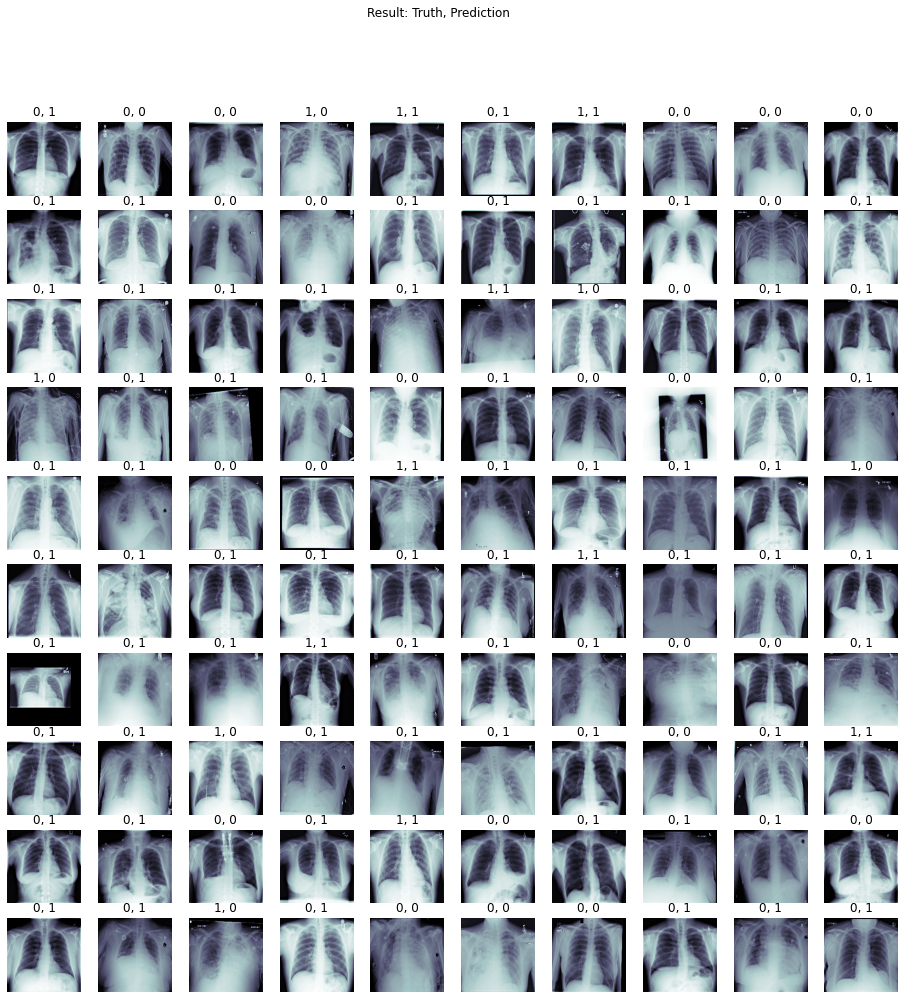

In [35]:
## Let's look at some examples of true vs. predicted with our best model: 
index=np.random.choice(range(1430), 100, replace=False)
# Todo
# real, predicted
fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
fig.suptitle('Result: Truth, Prediction')
i = 0
for (c_x, c_y, c_ax) in zip(valX_all[index], valY_all[index], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y_all[i] >  0.355:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y_all[i] >  0.355: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [62]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)

##### Explore how other diseases affect the model:


In [4]:
val_df['pred_bi']=0
val_df.loc[val_df['pred_Y']>0.355,'pred_bi']=1
val_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class,pred_Y,pred_bi
47098,00012010_001.png,Effusion,1,12010,54,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.429196,1
103834,00027725_008.png,Infiltration,8,27725,21,M,AP,3056,2544,0.139,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.300153,0
39069,00010224_000.png,Infiltration,0,10224,56,F,AP,2048,2500,0.168,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.496624,1


In [5]:
val_df_inf=val_df[val_df['Infiltration']==1]
val_df_inf.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class,pred_Y,pred_bi
19477,00005176_002.png,Infiltration,2,5176,66,M,AP,2500,2048,0.171,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.403817,1
52196,00013175_019.png,Infiltration,19,13175,28,M,PA,2508,3040,0.139,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.150817,0
63128,00015605_036.png,Edema|Infiltration|Pneumonia,36,15605,32,F,AP,2500,2048,0.168,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0.559085,1


In [59]:
tn, fp, fn, tp=confusion_matrix(val_df['Pneumonia'],val_df['pred_bi'],labels=[0,1]).ravel()
sens = tp/(tp+fn)
spec = tn/(tn+fp)
print('Sensitivity: '+ str(sens))
print('Specificity: ' +str(spec))

Sensitivity: 0.7027972027972028
Specificity: 0.5743006993006993


In [60]:
tn, fp, fn, tp=confusion_matrix(val_df_inf['Pneumonia'],val_df_inf['pred_bi'],labels=[0,1]).ravel()
sens = tp/(tp+fn)
spec = tn/(tn+fp)
print('Sensitivity: '+ str(sens))
print('Specificity: ' +str(spec))

Sensitivity: 0.7586206896551724
Specificity: 0.32019704433497537


**The presence of infiltration has an impact on specificity and may increase the number of false positive pneumonia classifications.**